# How to solve pressure poisson equation

We need to solve 

$$\mathbf{M}\mathbf{V}=\mathbf{M}\mathbf{G}\mathbf{p}$$

for the pressure.
Note that $\mathbf{M}\mathbf{G}=\mathbf{M}^T\mathbf{M} = \mathbf{A}$ is circulant and symmetric. Therefore, its eigenvectors are the discrete fourier modes (due to the circulant property) with real eigenvalues $\boldsymbol{\lambda}$ (due to the symmetry). By writing $\mathbf{M}\mathbf{V} = \mathbf{r}$ we find the pressure by solving 

$$\mathbf{A}\mathbf{p} = \mathbf{r}.$$

Using the eigendecomposition we can write $\mathbf{A}= \mathbf{F}^{-1}\text{diag}(\boldsymbol{\lambda})\mathbf{F}$, where $\mathbf{F}$ is a discrete fourier transform operator and $\mathbf{F}^{-1}=\mathbf{F}^T$ its inverse. We obtain the eigenvalues by doing

$$ \mathbf{F}\mathbf{A}\mathbf{F}^{-1}\mathbf{1} = \underbrace{\mathbf{F}\mathbf{F}^{-1}}_{=\mathbf{I}}\text{diag}(\boldsymbol{\lambda})\underbrace{\mathbf{F}\mathbf{F}^{-1}}_{=\mathbf{I}}\mathbf{1} = \boldsymbol{\lambda}.$$

After obtaining $\boldsymbol{\lambda}$ this allows us to invert $\mathbf{A}$ and obtain $\mathbf{p}$:

$$\mathbf{A}\mathbf{p} = \mathbf{r} \rightarrow   \mathbf{F}^{-1}\text{diag}(\boldsymbol{\lambda})\mathbf{F}\mathbf{p} = \mathbf{r} \rightarrow \mathbf{p} =  \mathbf{F}^{-1}\text{diag}(\boldsymbol{\lambda})^{-1}\mathbf{F}\mathbf{r}.$$

We can use a fast fourier transform to replace $\mathbf{F}$.

In [1]:
include("source.jl")
include("NS_FVM_solver.jl")



gen_setup (generic function with 1 method)

In [2]:
using Base.Threads

nthreads()

1

In [3]:
x= collect(LinRange(-pi,pi,257))
y = collect(LinRange(-pi,pi,257))
#z = collect(LinRange(-pi,pi,257))

UPC = 2
fine_mesh = gen_mesh(x,y,UPC = UPC)

# number of unknowns per cell

J = (16,16) # compression in each direction
coarse_mesh = generate_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0



┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = ConvTranspose((16, 16), 2 => 2, stride=16, bias=false)  # 1_024 parameters
│   summary(x) = "16×16×2×1 Array{Float64, 4}"
└ @ Flux ~/.julia/packages/Flux/jgpVj/src/layers/stateless.jl:60


0

In [6]:
using Profile
using PProf

In [7]:
# Collect an allocation profile
Profile.Allocs.clear()
Profile.Allocs.@profile peakflops()

# Export pprof allocation profile and open interactive profiling web interface.
PProf.Allocs.pprof()

Analyzing 162 allocation samples... 100%|████████████████| Time: 0:00:01


"alloc-profile.pb.gz"

Main binary filename not available.
Serving web UI on http://localhost:62261


# Define RHS of kolmogorov flow

In [14]:
forcing(x) = sin.(4*x[2])

F = fine_mesh.eval_function(forcing)
F = cat(F,zeros(size(F)),dims = fine_mesh.dims + 1)



function gen_kolmogorov_flow(setup,F;Re = 1000)
    
    
    function rhs(V,mesh,t;Re = Re,O=setup.O,PS = setup.PS,F = padding(F,(1,1),circular = true),solve_pressure = true,other_arguments = 0)

        dims = mesh.dims

        pad_V = padding(V,Tuple((3 for i in 1:dims)),circular = true)



        CV = O.C(pad_V)


        DV = (1/Re) .* O.D(pad_V[[(2:end-1) for i in 1:dims]...,:,:])

        rhs = -CV + DV

        #### kolmogorov flow ###
        
        rhs += F .- 0.1*pad_V[[(3:end-2) for i in 1:dims]...,:,:]

        ########################
       
        if solve_pressure 
            r = O.M(rhs)
            p = PS(r)
            return rhs[[(2:end-1) for i in 1:dims]...,:,:] - O.G(padding(p,Tuple((1 for i in 1:dims)),circular = true))
        else
            return rhs[[(2:end-1) for i in 1:dims]...,:,:] 
        end
        
    end
        
    return rhs
end

gen_kolmogorov_flow (generic function with 1 method)

# Generate divergence free initial condition

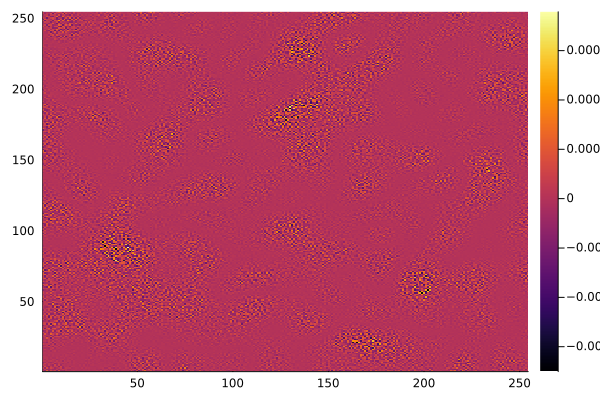

In [15]:
max_k = 10
energy_norm = 1
number_of_simulations = 1

setup = gen_setup(fine_mesh)
KF_rhs = gen_kolmogorov_flow(setup,F)

V = generate_random_field(fine_mesh.N,max_k,norm = energy_norm,samples = (fine_mesh.UPC,number_of_simulations))


    
MV = setup.O.M(padding(V,(1,1),circular = true))



p = setup.PS(MV)

Gp = setup.O.G(padding(p,(1,1),circular =true))

V0 = V-Gp

heatmap(setup.O.M(V0)[:,:,1,1])


# Warm-up

In [16]:
t_start = 0
t_end = 10
dt = 0.01
save_every = 1000
pre_allocate = true


t_data,w_up_sim_data = simulate(V0,fine_mesh,dt,t_start,t_end,KF_rhs,time_step,save_every = save_every,pre_allocate = pre_allocate) 
0


0.0%┣                                           ┫ 0/1.0k [00:01<-23:-44, -1s/it]
0.1%┣                                         ┫ 1/1.0k [00:03<Inf:Inf, InfGs/it]
0.2%┣                                              ┫ 2/1.0k [00:03<53:06, 3s/it]
0.3%┣▏                                             ┫ 3/1.0k [00:03<27:08, 2s/it]
0.4%┣▏                                             ┫ 4/1.0k [00:03<18:26, 1s/it]
0.5%┣▎                                             ┫ 5/1.0k [00:03<14:06, 1it/s]
0.6%┣▎                                             ┫ 6/1.0k [00:03<11:30, 1it/s]
0.7%┣▎                                             ┫ 7/1.0k [00:04<09:47, 2it/s]
0.8%┣▍                                             ┫ 8/1.0k [00:04<08:32, 2it/s]
0.9%┣▍                                             ┫ 9/1.0k [00:04<07:36, 2it/s]
1.0%┣▌                                            ┫ 10/1.0k [00:04<06:53, 2it/s]
1.1%┣▌                                            ┫ 11/1.0k [00:04<06:17, 3it/s]
1.2%┣▌                      

10.2%┣████▎                                     ┫ 102/1.0k [00:10<01:28, 10it/s]
10.3%┣████▎                                     ┫ 103/1.0k [00:10<01:28, 10it/s]
10.4%┣████▍                                     ┫ 104/1.0k [00:10<01:27, 10it/s]
10.5%┣████▍                                     ┫ 105/1.0k [00:10<01:27, 10it/s]
10.6%┣████▌                                     ┫ 106/1.0k [00:10<01:27, 10it/s]
10.7%┣████▌                                     ┫ 107/1.0k [00:10<01:26, 10it/s]
10.8%┣████▌                                     ┫ 108/1.0k [00:10<01:26, 10it/s]
10.9%┣████▋                                     ┫ 109/1.0k [00:10<01:26, 10it/s]
11.0%┣████▋                                     ┫ 110/1.0k [00:10<01:25, 10it/s]
11.1%┣████▋                                     ┫ 111/1.0k [00:11<01:25, 10it/s]
11.2%┣████▊                                     ┫ 112/1.0k [00:11<01:25, 11it/s]
11.3%┣████▊                                     ┫ 113/1.0k [00:11<01:24, 11it/s]
11.4%┣████▉                 

20.5%┣████████▋                                 ┫ 205/1.0k [00:17<01:06, 12it/s]
20.6%┣████████▋                                 ┫ 206/1.0k [00:17<01:06, 12it/s]
20.7%┣████████▊                                 ┫ 207/1.0k [00:17<01:06, 12it/s]
20.8%┣████████▊                                 ┫ 208/1.0k [00:17<01:05, 12it/s]
20.9%┣████████▉                                 ┫ 209/1.0k [00:17<01:05, 12it/s]
21.0%┣████████▉                                 ┫ 210/1.0k [00:17<01:05, 12it/s]
21.1%┣████████▉                                 ┫ 211/1.0k [00:17<01:05, 12it/s]
21.2%┣█████████                                 ┫ 212/1.0k [00:17<01:05, 12it/s]
21.3%┣█████████                                 ┫ 213/1.0k [00:17<01:05, 12it/s]
21.4%┣█████████                                 ┫ 214/1.0k [00:18<01:05, 12it/s]
21.5%┣█████████                                 ┫ 215/1.0k [00:18<01:05, 12it/s]
21.6%┣█████████                                 ┫ 216/1.0k [00:18<01:05, 12it/s]
21.7%┣█████████▏            

30.7%┣█████████████                             ┫ 307/1.0k [00:24<00:54, 13it/s]
30.8%┣█████████████                             ┫ 308/1.0k [00:24<00:54, 13it/s]
30.9%┣█████████████                             ┫ 309/1.0k [00:24<00:54, 13it/s]
31.0%┣█████████████                             ┫ 310/1.0k [00:24<00:54, 13it/s]
31.1%┣█████████████                             ┫ 311/1.0k [00:24<00:54, 13it/s]
31.2%┣█████████████                             ┫ 312/1.0k [00:24<00:54, 13it/s]
31.3%┣█████████████▏                            ┫ 313/1.0k [00:24<00:54, 13it/s]
31.4%┣█████████████▏                            ┫ 314/1.0k [00:24<00:54, 13it/s]
31.5%┣█████████████▎                            ┫ 315/1.0k [00:25<00:54, 13it/s]
31.6%┣█████████████▎                            ┫ 316/1.0k [00:25<00:53, 13it/s]
31.7%┣█████████████▎                            ┫ 317/1.0k [00:25<00:53, 13it/s]
31.8%┣█████████████▍                            ┫ 318/1.0k [00:25<00:53, 13it/s]
31.9%┣█████████████▍        

40.9%┣█████████████████▏                        ┫ 409/1.0k [00:31<00:45, 13it/s]
41.0%┣█████████████████▏                        ┫ 410/1.0k [00:31<00:45, 13it/s]
41.1%┣█████████████████▎                        ┫ 411/1.0k [00:31<00:44, 13it/s]
41.2%┣█████████████████▎                        ┫ 412/1.0k [00:31<00:44, 13it/s]
41.3%┣█████████████████▍                        ┫ 413/1.0k [00:31<00:44, 13it/s]
41.4%┣█████████████████▍                        ┫ 414/1.0k [00:31<00:44, 13it/s]
41.5%┣█████████████████▍                        ┫ 415/1.0k [00:31<00:44, 13it/s]
41.6%┣█████████████████▌                        ┫ 416/1.0k [00:31<00:44, 13it/s]
41.7%┣█████████████████▌                        ┫ 417/1.0k [00:31<00:44, 13it/s]
41.8%┣█████████████████▋                        ┫ 418/1.0k [00:31<00:44, 13it/s]
41.9%┣█████████████████▋                        ┫ 419/1.0k [00:32<00:44, 13it/s]
42.0%┣█████████████████▋                        ┫ 420/1.0k [00:32<00:44, 13it/s]
42.1%┣█████████████████▊    

51.1%┣█████████████████████▌                    ┫ 511/1.0k [00:38<00:36, 14it/s]
51.2%┣█████████████████████▌                    ┫ 512/1.0k [00:38<00:36, 14it/s]
51.3%┣█████████████████████▌                    ┫ 513/1.0k [00:38<00:36, 14it/s]
51.4%┣█████████████████████▋                    ┫ 514/1.0k [00:38<00:36, 14it/s]
51.5%┣█████████████████████▋                    ┫ 515/1.0k [00:38<00:36, 14it/s]
51.6%┣█████████████████████▊                    ┫ 516/1.0k [00:38<00:36, 14it/s]
51.7%┣█████████████████████▊                    ┫ 517/1.0k [00:38<00:36, 14it/s]
51.8%┣█████████████████████▊                    ┫ 518/1.0k [00:38<00:36, 14it/s]
51.9%┣█████████████████████▉                    ┫ 519/1.0k [00:38<00:36, 14it/s]
52.0%┣█████████████████████▉                    ┫ 520/1.0k [00:38<00:35, 14it/s]
52.1%┣█████████████████████▉                    ┫ 521/1.0k [00:38<00:35, 14it/s]
52.2%┣██████████████████████                    ┫ 522/1.0k [00:39<00:35, 14it/s]
52.3%┣██████████████████████

61.4%┣█████████████████████████▉                ┫ 614/1.0k [00:45<00:28, 14it/s]
61.5%┣█████████████████████████▉                ┫ 615/1.0k [00:45<00:28, 14it/s]
61.6%┣█████████████████████████▉                ┫ 616/1.0k [00:45<00:28, 14it/s]
61.7%┣██████████████████████████                ┫ 617/1.0k [00:45<00:28, 14it/s]
61.8%┣██████████████████████████                ┫ 618/1.0k [00:45<00:28, 14it/s]
61.9%┣██████████████████████████                ┫ 619/1.0k [00:45<00:28, 14it/s]
62.0%┣██████████████████████████                ┫ 620/1.0k [00:45<00:28, 14it/s]
62.1%┣██████████████████████████                ┫ 621/1.0k [00:45<00:28, 14it/s]
62.2%┣██████████████████████████▏               ┫ 622/1.0k [00:45<00:28, 14it/s]
62.3%┣██████████████████████████▏               ┫ 623/1.0k [00:45<00:27, 14it/s]
62.4%┣██████████████████████████▏               ┫ 624/1.0k [00:45<00:27, 14it/s]
62.5%┣██████████████████████████▎               ┫ 625/1.0k [00:45<00:27, 14it/s]
62.6%┣██████████████████████

71.6%┣██████████████████████████████            ┫ 716/1.0k [00:52<00:21, 14it/s]
71.7%┣██████████████████████████████▏           ┫ 717/1.0k [00:52<00:20, 14it/s]
71.8%┣██████████████████████████████▏           ┫ 718/1.0k [00:52<00:20, 14it/s]
71.9%┣██████████████████████████████▏           ┫ 719/1.0k [00:52<00:20, 14it/s]
72.0%┣██████████████████████████████▎           ┫ 720/1.0k [00:52<00:20, 14it/s]
72.1%┣██████████████████████████████▎           ┫ 721/1.0k [00:52<00:20, 14it/s]
72.2%┣██████████████████████████████▎           ┫ 722/1.0k [00:52<00:20, 14it/s]
72.3%┣██████████████████████████████▍           ┫ 723/1.0k [00:52<00:20, 14it/s]
72.4%┣██████████████████████████████▍           ┫ 724/1.0k [00:52<00:20, 14it/s]
72.5%┣██████████████████████████████▌           ┫ 725/1.0k [00:52<00:20, 14it/s]
72.6%┣██████████████████████████████▌           ┫ 726/1.0k [00:52<00:20, 14it/s]
72.7%┣██████████████████████████████▌           ┫ 727/1.0k [00:52<00:20, 14it/s]
72.8%┣██████████████████████

81.8%┣██████████████████████████████████▍       ┫ 818/1.0k [00:59<00:13, 14it/s]
81.9%┣██████████████████████████████████▍       ┫ 819/1.0k [00:59<00:13, 14it/s]
82.0%┣██████████████████████████████████▍       ┫ 820/1.0k [00:59<00:13, 14it/s]
82.1%┣██████████████████████████████████▌       ┫ 821/1.0k [00:59<00:13, 14it/s]
82.2%┣██████████████████████████████████▌       ┫ 822/1.0k [00:59<00:13, 14it/s]
82.3%┣██████████████████████████████████▋       ┫ 823/1.0k [00:59<00:13, 14it/s]
82.4%┣██████████████████████████████████▋       ┫ 824/1.0k [00:59<00:13, 14it/s]
82.5%┣██████████████████████████████████▋       ┫ 825/1.0k [00:59<00:13, 14it/s]
82.6%┣██████████████████████████████████▊       ┫ 826/1.0k [00:59<00:12, 14it/s]
82.7%┣██████████████████████████████████▊       ┫ 827/1.0k [00:59<00:12, 14it/s]
82.8%┣██████████████████████████████████▊       ┫ 828/1.0k [00:59<00:12, 14it/s]
82.9%┣██████████████████████████████████▉       ┫ 829/1.0k [00:59<00:12, 14it/s]
83.0%┣██████████████████████

92.1%┣██████████████████████████████████████▊   ┫ 921/1.0k [01:06<00:06, 14it/s]
92.2%┣██████████████████████████████████████▊   ┫ 922/1.0k [01:06<00:06, 14it/s]
92.3%┣██████████████████████████████████████▊   ┫ 923/1.0k [01:06<00:06, 14it/s]
92.4%┣██████████████████████████████████████▉   ┫ 924/1.0k [01:06<00:05, 14it/s]
92.5%┣██████████████████████████████████████▉   ┫ 925/1.0k [01:06<00:05, 14it/s]
92.6%┣███████████████████████████████████████   ┫ 926/1.0k [01:06<00:05, 14it/s]
92.7%┣███████████████████████████████████████   ┫ 927/1.0k [01:06<00:05, 14it/s]
92.8%┣███████████████████████████████████████   ┫ 928/1.0k [01:06<00:05, 14it/s]
92.9%┣███████████████████████████████████████   ┫ 929/1.0k [01:06<00:05, 14it/s]
93.0%┣███████████████████████████████████████   ┫ 930/1.0k [01:06<00:05, 14it/s]
93.1%┣███████████████████████████████████████   ┫ 931/1.0k [01:07<00:05, 14it/s]
93.2%┣███████████████████████████████████████▏  ┫ 932/1.0k [01:07<00:05, 14it/s]
93.3%┣██████████████████████

0

In [17]:
w_up_sim_data

256×256×2×1×1 Array{Float64, 5}:
[:, :, 1, 1, 1] =
 -0.474968   -0.517969   -0.561297   …  -0.359091   -0.394761   -0.433597
 -0.408295   -0.450874   -0.494979      -0.298929   -0.331587   -0.368247
 -0.338097   -0.379036   -0.422639      -0.240439   -0.26814    -0.300861
 -0.267056   -0.304224   -0.345668      -0.188077   -0.208746   -0.235075
 -0.200387   -0.230665   -0.266912      -0.145446   -0.158268   -0.176358
 -0.144089   -0.16504    -0.192585   …  -0.113545   -0.119307   -0.129146
 -0.101297   -0.112786   -0.130037      -0.0910551  -0.0914558  -0.0945392
 -0.0713978  -0.0751191  -0.0830476     -0.0762124  -0.0726888  -0.070867
 -0.0519078  -0.0499598  -0.0508105     -0.0685418  -0.0616516  -0.0559748
 -0.041128   -0.0347285  -0.0303445     -0.0687275  -0.0584539  -0.0491483
 -0.0391734  -0.0285217  -0.0196005  …  -0.07798    -0.0643017  -0.0512259
 -0.0474253  -0.0324024  -0.0187815     -0.0966159  -0.0799458  -0.0634161
 -0.0663414  -0.04727    -0.0292386     -0.126346   -0.1

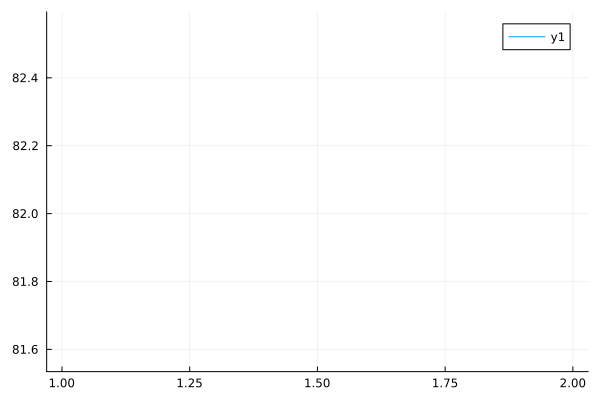

In [18]:
Plots.plot(fine_mesh.ip(w_up_sim_data,w_up_sim_data)[1:end])

# True sim

In [19]:
t_start = 0
t_end = 50
dt = 0.01
save_every = 10
pre_allocate = true


t_data,sim_data = simulate(w_up_sim_data[:,:,:,:,end],fine_mesh,dt,t_start,t_end,KF_rhs,time_step,save_every = save_every,pre_allocate = pre_allocate) 
0
data = reshape(sim_data,(size(sim_data)[1:end-2]...,size(sim_data)[end]*size(sim_data)[end-1]))


0.0%┣                                             ┫ 0/5.0k [00:00<00:00, -0s/it]
0.0%┣                                         ┫ 1/5.0k [00:00<Inf:Inf, InfGs/it]
0.0%┣                                              ┫ 2/5.0k [00:00<13:41, 6it/s]
0.1%┣                                              ┫ 3/5.0k [00:00<09:54, 8it/s]
0.1%┣                                             ┫ 4/5.0k [00:00<08:26, 10it/s]
0.1%┣                                             ┫ 5/5.0k [00:00<07:46, 11it/s]
0.1%┣                                             ┫ 6/5.0k [00:00<07:22, 11it/s]
0.1%┣                                             ┫ 7/5.0k [00:01<07:03, 12it/s]
0.2%┣                                             ┫ 8/5.0k [00:01<06:52, 12it/s]
0.2%┣                                             ┫ 9/5.0k [00:01<06:45, 12it/s]
0.2%┣                                            ┫ 10/5.0k [00:01<06:36, 13it/s]
0.2%┣                                            ┫ 11/5.0k [00:01<06:30, 13it/s]
0.2%┣                       

2.1%┣▉                                          ┫ 103/5.0k [00:07<05:39, 14it/s]
2.1%┣█                                          ┫ 104/5.0k [00:07<05:39, 14it/s]
2.1%┣█                                          ┫ 105/5.0k [00:07<05:39, 14it/s]
2.1%┣█                                          ┫ 106/5.0k [00:07<05:39, 14it/s]
2.1%┣█                                          ┫ 107/5.0k [00:07<05:38, 14it/s]
2.2%┣█                                          ┫ 108/5.0k [00:07<05:38, 14it/s]
2.2%┣█                                          ┫ 109/5.0k [00:07<05:38, 14it/s]
2.2%┣█                                          ┫ 110/5.0k [00:08<05:38, 14it/s]
2.2%┣█                                          ┫ 111/5.0k [00:08<05:38, 14it/s]
2.2%┣█                                          ┫ 112/5.0k [00:08<05:38, 14it/s]
2.3%┣█                                          ┫ 113/5.0k [00:08<05:38, 14it/s]
2.3%┣█                                          ┫ 114/5.0k [00:08<05:38, 14it/s]
2.3%┣█                      

4.1%┣█▊                                         ┫ 205/5.0k [00:14<05:29, 15it/s]
4.1%┣█▊                                         ┫ 206/5.0k [00:14<05:29, 15it/s]
4.1%┣█▉                                         ┫ 207/5.0k [00:14<05:29, 15it/s]
4.2%┣█▉                                         ┫ 208/5.0k [00:14<05:29, 15it/s]
4.2%┣█▉                                         ┫ 209/5.0k [00:14<05:29, 15it/s]
4.2%┣█▉                                         ┫ 210/5.0k [00:14<05:29, 15it/s]
4.2%┣█▉                                         ┫ 211/5.0k [00:14<05:29, 15it/s]
4.2%┣█▉                                         ┫ 212/5.0k [00:14<05:29, 15it/s]
4.3%┣█▉                                         ┫ 213/5.0k [00:15<05:29, 15it/s]
4.3%┣█▉                                         ┫ 214/5.0k [00:15<05:29, 15it/s]
4.3%┣█▉                                         ┫ 215/5.0k [00:15<05:29, 15it/s]
4.3%┣█▉                                         ┫ 216/5.0k [00:15<05:29, 15it/s]
4.3%┣█▉                     

6.2%┣██▋                                        ┫ 308/5.0k [00:21<05:22, 15it/s]
6.2%┣██▋                                        ┫ 309/5.0k [00:21<05:22, 15it/s]
6.2%┣██▋                                        ┫ 310/5.0k [00:21<05:22, 15it/s]
6.2%┣██▊                                        ┫ 311/5.0k [00:21<05:22, 15it/s]
6.2%┣██▊                                        ┫ 312/5.0k [00:21<05:22, 15it/s]
6.3%┣██▊                                        ┫ 313/5.0k [00:21<05:22, 15it/s]
6.3%┣██▊                                        ┫ 314/5.0k [00:22<05:22, 15it/s]
6.3%┣██▊                                        ┫ 315/5.0k [00:22<05:22, 15it/s]
6.3%┣██▊                                        ┫ 316/5.0k [00:22<05:22, 15it/s]
6.3%┣██▊                                        ┫ 317/5.0k [00:22<05:22, 15it/s]
6.4%┣██▊                                        ┫ 318/5.0k [00:22<05:22, 15it/s]
6.4%┣██▊                                        ┫ 319/5.0k [00:22<05:22, 15it/s]
6.4%┣██▊                    

8.2%┣███▌                                       ┫ 410/5.0k [00:28<05:16, 15it/s]
8.2%┣███▌                                       ┫ 411/5.0k [00:28<05:16, 15it/s]
8.2%┣███▌                                       ┫ 412/5.0k [00:28<05:16, 15it/s]
8.3%┣███▌                                       ┫ 413/5.0k [00:28<05:16, 15it/s]
8.3%┣███▋                                       ┫ 414/5.0k [00:28<05:16, 15it/s]
8.3%┣███▋                                       ┫ 415/5.0k [00:28<05:15, 15it/s]
8.3%┣███▋                                       ┫ 416/5.0k [00:29<05:15, 15it/s]
8.3%┣███▋                                       ┫ 417/5.0k [00:29<05:15, 15it/s]
8.4%┣███▋                                       ┫ 418/5.0k [00:29<05:15, 15it/s]
8.4%┣███▋                                       ┫ 419/5.0k [00:29<05:15, 15it/s]
8.4%┣███▋                                       ┫ 420/5.0k [00:29<05:15, 15it/s]
8.4%┣███▋                                       ┫ 421/5.0k [00:29<05:15, 15it/s]
8.4%┣███▋                   

10.3%┣████▎                                     ┫ 513/5.0k [00:35<05:09, 15it/s]
10.3%┣████▎                                     ┫ 514/5.0k [00:35<05:09, 15it/s]
10.3%┣████▎                                     ┫ 515/5.0k [00:35<05:09, 15it/s]
10.3%┣████▍                                     ┫ 516/5.0k [00:35<05:09, 15it/s]
10.3%┣████▍                                     ┫ 517/5.0k [00:36<05:09, 15it/s]
10.4%┣████▍                                     ┫ 518/5.0k [00:36<05:09, 15it/s]
10.4%┣████▍                                     ┫ 519/5.0k [00:36<05:09, 15it/s]
10.4%┣████▍                                     ┫ 520/5.0k [00:36<05:09, 15it/s]
10.4%┣████▍                                     ┫ 521/5.0k [00:36<05:09, 15it/s]
10.4%┣████▍                                     ┫ 522/5.0k [00:36<05:09, 15it/s]
10.5%┣████▍                                     ┫ 523/5.0k [00:36<05:09, 15it/s]
10.5%┣████▍                                     ┫ 524/5.0k [00:36<05:09, 15it/s]
10.5%┣████▍                 

12.3%┣█████▏                                    ┫ 615/5.0k [00:43<05:04, 14it/s]
12.3%┣█████▏                                    ┫ 616/5.0k [00:43<05:04, 14it/s]
12.3%┣█████▏                                    ┫ 617/5.0k [00:43<05:04, 14it/s]
12.4%┣█████▏                                    ┫ 618/5.0k [00:43<05:04, 14it/s]
12.4%┣█████▏                                    ┫ 619/5.0k [00:43<05:04, 14it/s]
12.4%┣█████▏                                    ┫ 620/5.0k [00:43<05:04, 14it/s]
12.4%┣█████▏                                    ┫ 621/5.0k [00:43<05:04, 14it/s]
12.4%┣█████▎                                    ┫ 622/5.0k [00:43<05:04, 14it/s]
12.5%┣█████▎                                    ┫ 623/5.0k [00:43<05:04, 14it/s]
12.5%┣█████▎                                    ┫ 624/5.0k [00:43<05:04, 14it/s]
12.5%┣█████▎                                    ┫ 625/5.0k [00:43<05:04, 14it/s]
12.5%┣█████▎                                    ┫ 626/5.0k [00:43<05:03, 14it/s]
12.5%┣█████▎                

14.3%┣██████                                    ┫ 717/5.0k [00:50<04:58, 14it/s]
14.4%┣██████                                    ┫ 718/5.0k [00:50<04:58, 14it/s]
14.4%┣██████                                    ┫ 719/5.0k [00:50<04:58, 14it/s]
14.4%┣██████                                    ┫ 720/5.0k [00:50<04:58, 14it/s]
14.4%┣██████                                    ┫ 721/5.0k [00:50<04:58, 14it/s]
14.4%┣██████                                    ┫ 722/5.0k [00:50<04:58, 14it/s]
14.5%┣██████                                    ┫ 723/5.0k [00:50<04:58, 14it/s]
14.5%┣██████                                    ┫ 724/5.0k [00:50<04:58, 14it/s]
14.5%┣██████                                    ┫ 725/5.0k [00:50<04:58, 14it/s]
14.5%┣██████                                    ┫ 726/5.0k [00:50<04:58, 14it/s]
14.5%┣██████                                    ┫ 727/5.0k [00:51<04:57, 14it/s]
14.6%┣██████▏                                   ┫ 728/5.0k [00:51<04:57, 14it/s]
14.6%┣██████▏               

16.4%┣██████▉                                   ┫ 819/5.0k [00:57<04:53, 14it/s]
16.4%┣██████▉                                   ┫ 820/5.0k [00:57<04:53, 14it/s]
16.4%┣███████                                   ┫ 821/5.0k [00:57<04:53, 14it/s]
16.4%┣███████                                   ┫ 822/5.0k [00:58<04:53, 14it/s]
16.5%┣███████                                   ┫ 823/5.0k [00:58<04:53, 14it/s]
16.5%┣███████                                   ┫ 824/5.0k [00:58<04:53, 14it/s]
16.5%┣███████                                   ┫ 825/5.0k [00:58<04:53, 14it/s]
16.5%┣███████                                   ┫ 826/5.0k [00:58<04:53, 14it/s]
16.5%┣███████                                   ┫ 827/5.0k [00:58<04:53, 14it/s]
16.6%┣███████                                   ┫ 828/5.0k [00:58<04:53, 14it/s]
16.6%┣███████                                   ┫ 829/5.0k [00:58<04:53, 14it/s]
16.6%┣███████                                   ┫ 830/5.0k [00:58<04:53, 14it/s]
16.6%┣███████               

18.4%┣███████▊                                  ┫ 921/5.0k [01:06<04:53, 14it/s]
18.4%┣███████▊                                  ┫ 922/5.0k [01:06<04:53, 14it/s]
18.5%┣███████▊                                  ┫ 923/5.0k [01:06<04:53, 14it/s]
18.5%┣███████▊                                  ┫ 924/5.0k [01:06<04:53, 14it/s]
18.5%┣███████▊                                  ┫ 925/5.0k [01:06<04:53, 14it/s]
18.5%┣███████▉                                  ┫ 926/5.0k [01:07<04:53, 14it/s]
18.5%┣███████▉                                  ┫ 927/5.0k [01:07<04:53, 14it/s]
18.6%┣███████▉                                  ┫ 928/5.0k [01:07<04:53, 14it/s]
18.6%┣███████▉                                  ┫ 929/5.0k [01:07<04:53, 14it/s]
18.6%┣███████▉                                  ┫ 930/5.0k [01:07<04:53, 14it/s]
18.6%┣███████▉                                  ┫ 931/5.0k [01:07<04:53, 14it/s]
18.6%┣███████▉                                  ┫ 932/5.0k [01:07<04:53, 14it/s]
18.7%┣███████▉              

20.5%┣████████▍                                ┫ 1.0k/5.0k [01:15<04:52, 14it/s]
20.5%┣████████▍                                ┫ 1.0k/5.0k [01:15<04:52, 14it/s]
20.5%┣████████▍                                ┫ 1.0k/5.0k [01:15<04:52, 14it/s]
20.5%┣████████▍                                ┫ 1.0k/5.0k [01:15<04:52, 14it/s]
20.5%┣████████▍                                ┫ 1.0k/5.0k [01:15<04:52, 14it/s]
20.6%┣████████▍                                ┫ 1.0k/5.0k [01:15<04:52, 14it/s]
20.6%┣████████▍                                ┫ 1.0k/5.0k [01:16<04:52, 14it/s]
20.6%┣████████▌                                ┫ 1.0k/5.0k [01:16<04:52, 14it/s]
20.6%┣████████▌                                ┫ 1.0k/5.0k [01:16<04:52, 14it/s]
20.6%┣████████▌                                ┫ 1.0k/5.0k [01:16<04:52, 14it/s]
20.7%┣████████▌                                ┫ 1.0k/5.0k [01:16<04:52, 14it/s]
20.7%┣████████▌                                ┫ 1.0k/5.0k [01:16<04:52, 14it/s]
20.7%┣████████▌             

22.5%┣█████████▎                               ┫ 1.1k/5.0k [01:24<04:49, 13it/s]
22.5%┣█████████▎                               ┫ 1.1k/5.0k [01:24<04:49, 13it/s]
22.5%┣█████████▎                               ┫ 1.1k/5.0k [01:24<04:49, 13it/s]
22.6%┣█████████▎                               ┫ 1.1k/5.0k [01:24<04:49, 13it/s]
22.6%┣█████████▎                               ┫ 1.1k/5.0k [01:24<04:49, 13it/s]
22.6%┣█████████▎                               ┫ 1.1k/5.0k [01:24<04:49, 13it/s]
22.6%┣█████████▎                               ┫ 1.1k/5.0k [01:24<04:49, 13it/s]
22.6%┣█████████▎                               ┫ 1.1k/5.0k [01:24<04:49, 13it/s]
22.7%┣█████████▎                               ┫ 1.1k/5.0k [01:25<04:49, 13it/s]
22.7%┣█████████▎                               ┫ 1.1k/5.0k [01:25<04:49, 13it/s]
22.7%┣█████████▎                               ┫ 1.1k/5.0k [01:25<04:49, 13it/s]
22.7%┣█████████▎                               ┫ 1.1k/5.0k [01:25<04:49, 13it/s]
22.7%┣█████████▎            

24.5%┣██████████                               ┫ 1.2k/5.0k [01:33<04:46, 13it/s]
24.6%┣██████████                               ┫ 1.2k/5.0k [01:33<04:46, 13it/s]
24.6%┣██████████                               ┫ 1.2k/5.0k [01:33<04:46, 13it/s]
24.6%┣██████████                               ┫ 1.2k/5.0k [01:33<04:46, 13it/s]
24.6%┣██████████                               ┫ 1.2k/5.0k [01:33<04:46, 13it/s]
24.6%┣██████████                               ┫ 1.2k/5.0k [01:33<04:46, 13it/s]
24.7%┣██████████                               ┫ 1.2k/5.0k [01:33<04:46, 13it/s]
24.7%┣██████████▏                              ┫ 1.2k/5.0k [01:34<04:46, 13it/s]
24.7%┣██████████▏                              ┫ 1.2k/5.0k [01:34<04:46, 13it/s]
24.7%┣██████████▏                              ┫ 1.2k/5.0k [01:34<04:46, 13it/s]
24.7%┣██████████▏                              ┫ 1.2k/5.0k [01:34<04:46, 13it/s]
24.8%┣██████████▏                              ┫ 1.2k/5.0k [01:34<04:46, 13it/s]
24.8%┣██████████▏           

26.6%┣███████████                              ┫ 1.3k/5.0k [01:45<04:51, 13it/s]
26.6%┣███████████                              ┫ 1.3k/5.0k [01:45<04:51, 13it/s]
26.6%┣███████████                              ┫ 1.3k/5.0k [01:45<04:50, 13it/s]
26.6%┣███████████                              ┫ 1.3k/5.0k [01:45<04:50, 13it/s]
26.7%┣███████████                              ┫ 1.3k/5.0k [01:45<04:50, 13it/s]
26.7%┣███████████                              ┫ 1.3k/5.0k [01:46<04:50, 13it/s]
26.7%┣███████████                              ┫ 1.3k/5.0k [01:46<04:50, 13it/s]
26.7%┣███████████                              ┫ 1.3k/5.0k [01:46<04:50, 13it/s]
26.7%┣███████████                              ┫ 1.3k/5.0k [01:46<04:50, 13it/s]
26.8%┣███████████                              ┫ 1.3k/5.0k [01:46<04:50, 13it/s]
26.8%┣███████████                              ┫ 1.3k/5.0k [01:46<04:50, 13it/s]
26.8%┣███████████                              ┫ 1.3k/5.0k [01:46<04:50, 13it/s]
26.8%┣███████████           

28.6%┣███████████▊                             ┫ 1.4k/5.0k [01:53<04:42, 13it/s]
28.6%┣███████████▊                             ┫ 1.4k/5.0k [01:53<04:42, 13it/s]
28.7%┣███████████▊                             ┫ 1.4k/5.0k [01:53<04:42, 13it/s]
28.7%┣███████████▊                             ┫ 1.4k/5.0k [01:53<04:42, 13it/s]
28.7%┣███████████▊                             ┫ 1.4k/5.0k [01:53<04:42, 13it/s]
28.7%┣███████████▊                             ┫ 1.4k/5.0k [01:53<04:42, 13it/s]
28.7%┣███████████▉                             ┫ 1.4k/5.0k [01:54<04:42, 13it/s]
28.8%┣███████████▉                             ┫ 1.4k/5.0k [01:54<04:42, 13it/s]
28.8%┣███████████▉                             ┫ 1.4k/5.0k [01:54<04:42, 13it/s]
28.8%┣███████████▉                             ┫ 1.4k/5.0k [01:54<04:41, 13it/s]
28.8%┣███████████▉                             ┫ 1.4k/5.0k [01:54<04:41, 13it/s]
28.8%┣███████████▉                             ┫ 1.4k/5.0k [01:54<04:41, 13it/s]
28.9%┣███████████▉          

30.7%┣████████████▋                            ┫ 1.5k/5.0k [02:01<04:34, 13it/s]
30.7%┣████████████▋                            ┫ 1.5k/5.0k [02:01<04:34, 13it/s]
30.7%┣████████████▋                            ┫ 1.5k/5.0k [02:01<04:34, 13it/s]
30.7%┣████████████▋                            ┫ 1.5k/5.0k [02:01<04:34, 13it/s]
30.7%┣████████████▋                            ┫ 1.5k/5.0k [02:01<04:34, 13it/s]
30.8%┣████████████▋                            ┫ 1.5k/5.0k [02:02<04:34, 13it/s]
30.8%┣████████████▋                            ┫ 1.5k/5.0k [02:02<04:34, 13it/s]
30.8%┣████████████▋                            ┫ 1.5k/5.0k [02:02<04:34, 13it/s]
30.8%┣████████████▋                            ┫ 1.5k/5.0k [02:02<04:34, 13it/s]
30.8%┣████████████▋                            ┫ 1.5k/5.0k [02:02<04:34, 13it/s]
30.9%┣████████████▋                            ┫ 1.5k/5.0k [02:02<04:34, 13it/s]
30.9%┣████████████▋                            ┫ 1.5k/5.0k [02:02<04:33, 13it/s]
30.9%┣████████████▊         

32.7%┣█████████████▍                           ┫ 1.6k/5.0k [02:09<04:26, 13it/s]
32.7%┣█████████████▍                           ┫ 1.6k/5.0k [02:09<04:26, 13it/s]
32.7%┣█████████████▍                           ┫ 1.6k/5.0k [02:09<04:26, 13it/s]
32.8%┣█████████████▍                           ┫ 1.6k/5.0k [02:09<04:26, 13it/s]
32.8%┣█████████████▍                           ┫ 1.6k/5.0k [02:09<04:26, 13it/s]
32.8%┣█████████████▌                           ┫ 1.6k/5.0k [02:10<04:25, 13it/s]
32.8%┣█████████████▌                           ┫ 1.6k/5.0k [02:10<04:25, 13it/s]
32.8%┣█████████████▌                           ┫ 1.6k/5.0k [02:10<04:25, 13it/s]
32.9%┣█████████████▌                           ┫ 1.6k/5.0k [02:10<04:25, 13it/s]
32.9%┣█████████████▌                           ┫ 1.6k/5.0k [02:10<04:25, 13it/s]
32.9%┣█████████████▌                           ┫ 1.6k/5.0k [02:10<04:25, 13it/s]
32.9%┣█████████████▌                           ┫ 1.6k/5.0k [02:10<04:25, 13it/s]
32.9%┣█████████████▌        

34.7%┣██████████████▎                          ┫ 1.7k/5.0k [02:17<04:17, 13it/s]
34.8%┣██████████████▎                          ┫ 1.7k/5.0k [02:17<04:17, 13it/s]
34.8%┣██████████████▎                          ┫ 1.7k/5.0k [02:17<04:17, 13it/s]
34.8%┣██████████████▎                          ┫ 1.7k/5.0k [02:17<04:17, 13it/s]
34.8%┣██████████████▎                          ┫ 1.7k/5.0k [02:17<04:17, 13it/s]
34.8%┣██████████████▎                          ┫ 1.7k/5.0k [02:17<04:17, 13it/s]
34.9%┣██████████████▎                          ┫ 1.7k/5.0k [02:17<04:17, 13it/s]
34.9%┣██████████████▎                          ┫ 1.7k/5.0k [02:17<04:17, 13it/s]
34.9%┣██████████████▎                          ┫ 1.7k/5.0k [02:18<04:17, 13it/s]
34.9%┣██████████████▎                          ┫ 1.7k/5.0k [02:18<04:17, 13it/s]
34.9%┣██████████████▎                          ┫ 1.7k/5.0k [02:18<04:17, 13it/s]
35.0%┣██████████████▍                          ┫ 1.7k/5.0k [02:18<04:17, 13it/s]
35.0%┣██████████████▍       

36.8%┣███████████████                          ┫ 1.8k/5.0k [02:25<04:09, 13it/s]
36.8%┣███████████████                          ┫ 1.8k/5.0k [02:25<04:09, 13it/s]
36.8%┣███████████████                          ┫ 1.8k/5.0k [02:25<04:09, 13it/s]
36.8%┣███████████████                          ┫ 1.8k/5.0k [02:25<04:09, 13it/s]
36.9%┣███████████████▏                         ┫ 1.8k/5.0k [02:25<04:09, 13it/s]
36.9%┣███████████████▏                         ┫ 1.8k/5.0k [02:25<04:09, 13it/s]
36.9%┣███████████████▏                         ┫ 1.8k/5.0k [02:25<04:09, 13it/s]
36.9%┣███████████████▏                         ┫ 1.8k/5.0k [02:25<04:09, 13it/s]
36.9%┣███████████████▏                         ┫ 1.8k/5.0k [02:26<04:09, 13it/s]
37.0%┣███████████████▏                         ┫ 1.8k/5.0k [02:26<04:09, 13it/s]
37.0%┣███████████████▏                         ┫ 1.8k/5.0k [02:26<04:08, 13it/s]
37.0%┣███████████████▏                         ┫ 1.9k/5.0k [02:26<04:08, 13it/s]
37.0%┣███████████████▏      

38.8%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:01, 13it/s]
38.8%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:01, 13it/s]
38.9%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:00, 13it/s]
38.9%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:00, 13it/s]
38.9%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:00, 13it/s]
38.9%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:00, 13it/s]
38.9%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:00, 13it/s]
39.0%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:00, 13it/s]
39.0%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:00, 13it/s]
39.0%┣████████████████                         ┫ 1.9k/5.0k [02:33<04:00, 13it/s]
39.0%┣████████████████                         ┫ 2.0k/5.0k [02:33<04:00, 13it/s]
39.0%┣████████████████                         ┫ 2.0k/5.0k [02:33<04:00, 13it/s]
39.1%┣████████████████      

40.9%┣████████████████▊                        ┫ 2.0k/5.0k [02:40<03:52, 13it/s]
40.9%┣████████████████▊                        ┫ 2.0k/5.0k [02:40<03:52, 13it/s]
40.9%┣████████████████▊                        ┫ 2.0k/5.0k [02:41<03:52, 13it/s]
40.9%┣████████████████▉                        ┫ 2.0k/5.0k [02:41<03:52, 13it/s]
41.0%┣████████████████▉                        ┫ 2.0k/5.0k [02:41<03:52, 13it/s]
41.0%┣████████████████▉                        ┫ 2.0k/5.0k [02:41<03:52, 13it/s]
41.0%┣████████████████▉                        ┫ 2.0k/5.0k [02:41<03:52, 13it/s]
41.0%┣████████████████▉                        ┫ 2.1k/5.0k [02:41<03:52, 13it/s]
41.0%┣████████████████▉                        ┫ 2.1k/5.0k [02:41<03:51, 13it/s]
41.1%┣████████████████▉                        ┫ 2.1k/5.0k [02:41<03:51, 13it/s]
41.1%┣████████████████▉                        ┫ 2.1k/5.0k [02:41<03:51, 13it/s]
41.1%┣████████████████▉                        ┫ 2.1k/5.0k [02:41<03:51, 13it/s]
41.1%┣████████████████▉     

42.9%┣█████████████████▋                       ┫ 2.1k/5.0k [02:48<03:44, 13it/s]
43.0%┣█████████████████▋                       ┫ 2.1k/5.0k [02:48<03:43, 13it/s]
43.0%┣█████████████████▋                       ┫ 2.1k/5.0k [02:48<03:43, 13it/s]
43.0%┣█████████████████▋                       ┫ 2.1k/5.0k [02:48<03:43, 13it/s]
43.0%┣█████████████████▋                       ┫ 2.2k/5.0k [02:48<03:43, 13it/s]
43.0%┣█████████████████▋                       ┫ 2.2k/5.0k [02:49<03:43, 13it/s]
43.1%┣█████████████████▋                       ┫ 2.2k/5.0k [02:49<03:43, 13it/s]
43.1%┣█████████████████▋                       ┫ 2.2k/5.0k [02:49<03:43, 13it/s]
43.1%┣█████████████████▊                       ┫ 2.2k/5.0k [02:49<03:43, 13it/s]
43.1%┣█████████████████▊                       ┫ 2.2k/5.0k [02:49<03:43, 13it/s]
43.1%┣█████████████████▊                       ┫ 2.2k/5.0k [02:49<03:43, 13it/s]
43.2%┣█████████████████▊                       ┫ 2.2k/5.0k [02:49<03:43, 13it/s]
43.2%┣█████████████████▊    

45.0%┣██████████████████▌                      ┫ 2.2k/5.0k [02:56<03:35, 13it/s]
45.0%┣██████████████████▌                      ┫ 2.3k/5.0k [02:56<03:35, 13it/s]
45.0%┣██████████████████▌                      ┫ 2.3k/5.0k [02:56<03:35, 13it/s]
45.1%┣██████████████████▌                      ┫ 2.3k/5.0k [02:56<03:35, 13it/s]
45.1%┣██████████████████▌                      ┫ 2.3k/5.0k [02:56<03:35, 13it/s]
45.1%┣██████████████████▌                      ┫ 2.3k/5.0k [02:56<03:35, 13it/s]
45.1%┣██████████████████▌                      ┫ 2.3k/5.0k [02:56<03:35, 13it/s]
45.1%┣██████████████████▌                      ┫ 2.3k/5.0k [02:56<03:35, 13it/s]
45.2%┣██████████████████▌                      ┫ 2.3k/5.0k [02:57<03:34, 13it/s]
45.2%┣██████████████████▌                      ┫ 2.3k/5.0k [02:57<03:34, 13it/s]
45.2%┣██████████████████▌                      ┫ 2.3k/5.0k [02:57<03:34, 13it/s]
45.2%┣██████████████████▌                      ┫ 2.3k/5.0k [02:57<03:34, 13it/s]
45.2%┣██████████████████▌   

47.0%┣███████████████████▎                     ┫ 2.4k/5.0k [03:04<03:27, 13it/s]
47.1%┣███████████████████▎                     ┫ 2.4k/5.0k [03:04<03:27, 13it/s]
47.1%┣███████████████████▎                     ┫ 2.4k/5.0k [03:04<03:27, 13it/s]
47.1%┣███████████████████▎                     ┫ 2.4k/5.0k [03:04<03:27, 13it/s]
47.1%┣███████████████████▎                     ┫ 2.4k/5.0k [03:04<03:27, 13it/s]
47.1%┣███████████████████▎                     ┫ 2.4k/5.0k [03:04<03:26, 13it/s]
47.2%┣███████████████████▍                     ┫ 2.4k/5.0k [03:04<03:26, 13it/s]
47.2%┣███████████████████▍                     ┫ 2.4k/5.0k [03:04<03:26, 13it/s]
47.2%┣███████████████████▍                     ┫ 2.4k/5.0k [03:04<03:26, 13it/s]
47.2%┣███████████████████▍                     ┫ 2.4k/5.0k [03:04<03:26, 13it/s]
47.2%┣███████████████████▍                     ┫ 2.4k/5.0k [03:04<03:26, 13it/s]
47.3%┣███████████████████▍                     ┫ 2.4k/5.0k [03:04<03:26, 13it/s]
47.3%┣███████████████████▍  

49.1%┣████████████████████▏                    ┫ 2.5k/5.0k [03:11<03:19, 13it/s]
49.1%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:19, 13it/s]
49.1%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.2%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.2%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.2%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.2%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.2%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.3%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.3%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.3%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.3%┣████████████████████▏                    ┫ 2.5k/5.0k [03:12<03:18, 13it/s]
49.3%┣████████████████████▎ 

In [20]:
Plots.plot(fine_mesh.ip(sim_data[:,:,:,1,:],sim_data[:,:,:,1,:])[1:end])

In [ ]:
to_plot = setup.O.w(sim_data[:,:,:,1,:])[:,:,1,:]

ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Simplified ocean model",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

# Generate local POD model

In [13]:
conserve_momentum = true
### momentum conserving correction of data set

data_hat = sqrt.(MP.omega_tilde) .* setup.GS.A_s_c(data)
reshape_for_local_SVD(data_hat,MP)

POD_modes,S = carry_out_local_SVD(data_hat,MP,subtract_average = conserve_momentum)

0

LoadError: UndefVarError: `MP` not defined

In [14]:
Plots.plot(S,marker = true,yscale = :log)
hline!([0.01])

LoadError: UndefVarError: `Plots` not defined

In [15]:
r =30 #how many modes to include, including u_bar
uniform = true

if conserve_momentum 
    if r >= UPC + 1
        global_POD_modes = local_to_global_modes(POD_modes[[(:) for i in 1:fine_mesh.dims]...,:,1:(r-UPC)],MP)

    else
        global_POD_modes = 0
    end

    global_POD_modes = add_filter_to_modes(global_POD_modes,MP,orthogonalize = !uniform)

else
    global_POD_modes = local_to_global_modes(POD_modes[[(:) for i in 1:fine_mesh.dims]...,:,1:r],MP)
end

PO = gen_projection_operators(global_POD_modes,MP,uniform =uniform)



LoadError: UndefVarError: `fine_mesh` not defined

In [16]:
function true_W(u,setup,setup_bar,PO)
    
    UPC = setup.mesh.UPC
    dims = setup.mesh.dims

    
    a = PO.W(setup.GS.A_s_c(u))
    
    u_bar_c = a[[(:) for i in 1:dims]...,1:UPC,:]

    u_bar_s = setup_bar.GS.A_c_s(u_bar_c)
    
    r = setup_bar.O.M(padding(u_bar_s,Tuple((1 for i in 1:dims)),circular = true))
    p = setup_bar.PS(r)
    
    Gp = setup_bar.O.G(padding(p,Tuple((1 for i in 1:dims)),circular = true))
    
    u_bar_s -= Gp
    
    return cat(u_bar_s,a[[(:) for i in 1:dims]...,UPC+1:end,:],dims = dims+1)
end

function true_R(a,setup,setup_bar,PO)
    
    UPC = setup.mesh.UPC
    dims = setup.mesh.dims
    
    u_bar_s = a[[(:) for i in 1:dims]...,1:UPC,:]
    
    u_bar_s = setup_bar.GS.A_s_c(u_bar_s)
    
    u_r = setup.GS.A_c_s(PO.R(cat(u_bar_s,a[[(:) for i in 1:dims]...,UPC+1:end,:],dims = dims+1)))
    
    r = setup.O.M(padding(u_r,Tuple((1 for i in 1:dims)),circular = true))
    p = setup.PS(r)

    Gp = setup.O.G(padding(p,Tuple((1 for i in 1:dims)),circular = true))
    
    u_r -= Gp
    
    
    return u_r
end


true_R (generic function with 1 method)

# True filter

In [17]:

setup_bar = gen_setup(coarse_mesh)

W(u,setup = setup,setup_bar = setup_bar,PO = PO) = true_W(u,setup,setup_bar,PO)
R(a,setup = setup,setup_bar = setup_bar,PO = PO) = true_R(a,setup,setup_bar,PO)

ref_data = W(data)
#a_rhs = true_W(KF_rhs(data,setup.mesh,0),setup,setup_bar,PO)
F_a = W(F)
rhs_bar = gen_kolmogorov_flow(setup_bar,F_a[:,:,1:2,:];Re = 1000)
0



LoadError: UndefVarError: `coarse_mesh` not defined

In [18]:
scatter(fine_mesh.ip(data,data)[1:end],coarse_mesh.ip(ref_data,ref_data)[1:end])

LoadError: UndefVarError: `fine_mesh` not defined

In [19]:
kernel_sizes = [(1,1),(1,1)]
channels = [r+2,30] # r+2 as the first channels are the coarse rhs
strides = [(1,1),(1,1)]
B = (1,1)
boundary_padding = "c" #[["c","c"];;[0,0]]


constrain_energy =true
dissipation = true
conserve_momentum =true


model = gen_skew_NN(kernel_sizes,channels,strides,r,B,boundary_padding = boundary_padding,UPC = coarse_mesh.UPC,constrain_energy = constrain_energy,dissipation = dissipation,conserve_momentum = conserve_momentum)

LoadError: UndefVarError: `coarse_mesh` not defined

In [20]:
function neural_rhs(a,mesh,t,rhs = rhs_bar,setup = setup_bar,model = model,F = F_a,B=B;other_arguments = 0)
    
    
    dims = mesh.dims
    
    u_s = a[:,:,1:2,:]
    
    RHS = rhs(u_s,mesh,t,solve_pressure = false)
    
    RHS_c = setup.GS.A_s_c(RHS)
    u_c = setup.GS.A_s_c(u_s)
    
    a_c = cat(u_c,a[:,:,3:end,:],dims = dims+1)
    
    input = cat(RHS_c,a,dims = dims +1)  

    nn_output = model.eval(input,a = padding(a_c,((2*[B...])...,),circular = true))
    
    nn_output = cat(setup.GS.A_c_s(nn_output[:,:,1:2,:]),nn_output[:,:,3:end,:],dims = dims+1)
    ### find pressure based on NN_output
    #+ nn_output[:,:,1:2,:]
    r = setup.O.M(padding(RHS + nn_output[:,:,1:2,:] ,(1,1),circular = true))
    
    p = setup.PS(r)
    
    Gp = setup.O.G(padding(p,(1,1),circular = true))
     
    ####################################

    physics_rhs = cat( RHS -Gp , - 0.1 * a[:,:,3:end,:] .+ F[:,:,3:end,:] ,dims = dims +1) # from kolmogorov flow

    return nn_output +   physics_rhs
    
    
end

neural_rhs (generic function with 6 methods)

In [21]:
function galerkin_rhs(a,mesh,t,setup = setup,W=W,R = R,rhs = KF_rhs;other_arguments = 0)
    V = R(a)
    dadt = W(rhs(V,setup.mesh,t))
    return dadt
end

galerkin_rhs (generic function with 5 methods)

In [22]:
galerkin_rhs(ref_data,coarse_mesh,0)

LoadError: UndefVarError: `ref_data` not defined

# Trajectory fitting

In [23]:
simulation_indexes = collect(1:size(sim_data)[end-1])'
simulation_indexes = cat([simulation_indexes for i in 1:size(sim_data)[end]]...,dims = fine_mesh.dims + 2)
simulation_indexes = simulation_indexes[1:end]
simulation_times = t_data[1:end]

ref_data_trajectory = reshape(ref_data,(size(ref_data)[1:coarse_mesh.dims+1]...,size(sim_data)[end-1],size(sim_data)[end]))
        

sim_interpolator = gen_time_interpolator(t_data,ref_data_trajectory)





LoadError: UndefVarError: `sim_data` not defined

In [24]:
# remove data that lies at the end of the simulation
buffer_dt = 0.6
select = buffer_dt .< maximum(simulation_times) .- simulation_times

traj_data = ref_data[[(:) for i in 1:coarse_mesh.dims+1]...,select]
traj_indexes = simulation_indexes[select]
traj_times = simulation_times[select]

LoadError: UndefVarError: `simulation_times` not defined

In [25]:
traj_dt = 0.1
traj_steps = 5

function trajectory_fitting_loss(input,indexes,times,dt = traj_dt,steps = traj_steps,sim_interpolator = sim_interpolator,neural_rhs = neural_rhs,coarse_mesh = coarse_mesh)
    dims = length(size(input)) - 2
    
    t_start = reshape(times,([1 for i in 1:dims+1]...,size(times)[1]))
    t_end =  t_start .+ steps *dt
    t,result = simulate(input,coarse_mesh,dt,t_start,t_end,neural_rhs,time_step,save_every = 1,pre_allocate = false) 
    reference = stop_gradient() do
        sim_interpolator(t,simulation_indexes = indexes)
    end
    return Flux.Losses.mse(result,reference)
end    
    
    
    
    

trajectory_fitting_loss (generic function with 6 methods)

In [26]:
batchsize = 5
trajectory_fitting_data_loader = Flux.Data.DataLoader((traj_data,traj_indexes,traj_times), batchsize=batchsize,shuffle=true)

LoadError: UndefVarError: `Flux` not defined

In [27]:
select = rand(collect(1:prod(size(traj_indexes))),(50))
sqrt.(trajectory_fitting_loss(traj_data[:,:,:,select],traj_indexes[select],traj_times[select]))

LoadError: UndefVarError: `traj_indexes` not defined

In [28]:
opt = ADAM()

LoadError: UndefVarError: `ADAM` not defined

In [29]:
ps = Flux.params(model.CNN,model.B_mats...)
epochs = 90
losses = zeros(epochs)
for epoch in tqdm(1:epochs)
    Flux.train!(trajectory_fitting_loss,ps, trajectory_fitting_data_loader, opt)
    train_loss = trajectory_fitting_loss(traj_data[:,:,:,select],traj_indexes[select],traj_times[select])
    losses[epoch] = train_loss
end

LoadError: UndefVarError: `Flux` not defined

In [30]:
plot(sqrt.(losses))

LoadError: UndefVarError: `losses` not defined

In [31]:
t_start = 0
t_end = 20
dt = 0.1
save_every = 1
pre_allocate = true
init_cond = true_W(w_up_sim_data[:,:,:,1,end:end],setup,setup_bar,PO)

t,pred_sim = simulate(init_cond,coarse_mesh,dt,t_start,t_end,neural_rhs,time_step,save_every = save_every,pre_allocate = pre_allocate) 
t_pred = t[1:end]
pred_sim = pred_sim[:,:,:,1,:]



LoadError: UndefVarError: `w_up_sim_data` not defined

In [32]:
Plots.plot(fine_mesh.ip(sim_data[:,:,:,1,:],sim_data[:,:,:,1,:])[1:end])

LoadError: UndefVarError: `Plots` not defined

In [33]:
plot(coarse_mesh.ip(pred_sim,pred_sim)[1:end])
plot!(coarse_mesh.ip(W(sim_data[:,:,:,1,:]),W(sim_data[:,:,:,1,:]))[1:end])

LoadError: UndefVarError: `coarse_mesh` not defined

In [34]:
to_plot = setup.O.w(R(pred_sim))[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]


ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Simplified ocean model",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

LoadError: UndefVarError: `setup` not defined

In [35]:
to_plot = setup.O.w(R(W(sim_data[:,:,:,1,:])))[:,:,1,:]

ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Simplified ocean model",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

LoadError: UndefVarError: `setup` not defined

In [36]:
lit = coarse_mesh.ip(pred_sim,pred_sim,combine_channels = false)[1,1,:,:]

LoadError: UndefVarError: `coarse_mesh` not defined